# We're going to combine all components into a single model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os
import sys

import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import arviz
import warnings
warnings.filterwarnings('ignore')

cpu = 'bear'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi = p

        # Unpack background parameters
        loga = phi[0]
        logb = phi[1]
        logc = phi[2]
        logd = phi[3]
        logj = phi[4]
        logk = phi[5]
        white = phi[6]
        scale = phi[7]
        nyq = phi[8]
        
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()
        
    def harvey(self, a, b, c):
        harvey = 0.9*tt.sqr(a)/b/(1.0 + tt.pow((self.f/b), c))
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return tt.sqr((tt.sin(x)/x))

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(tt.pow(10, loga), tt.pow(10, logb), 4.) \
                        +  self.harvey(tt.pow(10, logc), tt.pow(10, logd), 4.) \
                        +  self.harvey(tt.pow(10, logj), tt.pow(10, logk), 2.))\
                        +  white
        return background              

### Build the range

In [32]:
nmodes = 4
nbase = 16
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

### Build the frequencies

In [33]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [34]:
mod = model(ff, n0_, n1_, n2_, deltanu_)

In [35]:
init_f = [numax_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [36]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

### Reset model for new frequency range

In [37]:
mod = model(f, n0_, n1_, n2_, deltanu_)

### Build the linewidths

In [38]:
def kernel(n, rho, L):
    return rho**2 * np.exp(-0.5 * np.subtract.outer(n,n)**2 / L**2)

In [39]:
m_ = .5
c_ = .5
rho_ = 0.1
L_ = 0.3

fs = np.concatenate((f0_, f1_, f2_))
fs -= fs.min()
nf = fs/fs.max()
mu_ = m_ * nf + c_

Sigma_ = kernel(nf, rho_, L_)

lng0_ = np.random.multivariate_normal(mu_, Sigma_)
widths = [np.exp(lng0_)[0:len(f0_)],
          np.exp(lng0_)[len(f0_):len(f0_)+len(f1_)],
          np.exp(lng0_)[len(f0_)+len(f1_):]]

nf_ = nf[:,None]

### Build the mode amplitudes

In [40]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_]

### Build the background

In [41]:
labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
phi_ =  [   1.6,   2.6,   1.6,   3.0,   1.7,   0.5,    0.4,     1., nyq]
phi_sigma = np.genfromtxt('phi_sigma.txt')
phi_cholesky = np.linalg.cholesky(phi_sigma)

### Construct the model

In [42]:
split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       phi_                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

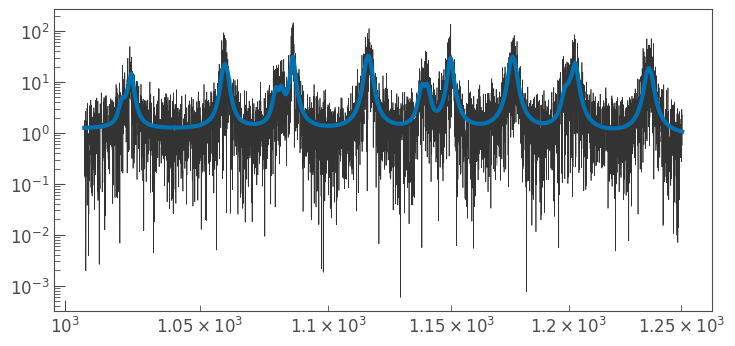

In [43]:
with plt.style.context(lk.MPLSTYLE):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.yscale('log')
    plt.xscale('log')
    if cpu == 'bear':
        plt.savefig('data.png')
    else: plt.show()

## First lets fit the background alone...

In [15]:
if cpu != 'bear':
    pm_model = pm.Model()

    with pm_model:   
        # Background treatment
        phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))

        # Construct the model
        fit = mod.model([*init_m[:11], phi])
        like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

        trace = pm.sample(target_accept=.99)

In [16]:
if cpu != 'bear':
    pm.summary(trace)

In [17]:
if cpu != 'bear':
    labels=['loga','logb','logc','logd','logj','logk',
            'white','scale','nyq']
    verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
            r'$\log_{10}c$',r'$\log_{10}d$',
            r'$\log_{10}j$',r'$\log_{10}k$',
            'white','scale',r'$\nu_{\rm nyq}$']

    phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
    truth = phi_

    corner.corner(phichain, truths=truth, show_titles=True, labels=verbose)
    plt.show()

# Now lets try and fit this

## Building the initial guesses

In [44]:
init = {}
init['numax'] = numax_
init['alpha'] = alpha_
init['epsilon'] = epsilon_
init['d01'] = d01_
init['d02'] = d02_
init['sigma0'] = sigma0_
init['sigma1'] = sigma1_
init['sigma2'] = sigma2_

init['m'] = m_
init['c'] = c_
init['rho'] = rho_
init['L'] = L_


init['w'] = (0.25 * numax_)/2.355
init['A'] = np.sqrt(np.pi * np.nanmax(p) / 2.)
init['V1'] = V1_
init['V2'] = V2_
init['sigmaA'] = sigmaA_

init['a0'] = amps[0]
init['a1'] = amps[1]
init['a2'] = amps[2]

init['xsplit'] = split_ * np.sin(incl_)
init['cosi'] = np.cos(incl_)

## Building the model

In [45]:
pm_model = pm.Model()

with pm_model:   
     # Mode locations
    numax =  pm.Normal('numax', init['numax'], 10., testval = init['numax'])
    alpha =  pm.Lognormal('alpha', np.log(init['alpha']), 0.01, testval = init['alpha'])
    epsilon = pm.Normal('epsilon', init['epsilon'], 1., testval = init['epsilon'])
    d01     = pm.Lognormal('d01', np.log(init['d01']), 0.1, testval = init['d01'])
    d02     = pm.Lognormal('d02', np.log(init['d02']), 0.1, testval = init['d02'])

    sigma0 = pm.HalfCauchy('sigma0', 2., testval = init['sigma0'])
    sigma1 = pm.HalfCauchy('sigma1', 2., testval = init['sigma1'])
    sigma2 = pm.HalfCauchy('sigma2', 2., testval = init['sigma2'])

    f0 = pm.Normal('f0', mod.f0([numax, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, alpha, epsilon, d01, d02]), sigma1, shape=len(f1_))
    f2 = pm.Normal('f2', mod.f2([numax, alpha, epsilon, d01, d02]), sigma2, shape=len(f2_))

    # Mode Linewidths
    m = pm.Normal('m', init['m'], 1., testval = init['m'])
    c = pm.Normal('c', init['c'], 1., testval = init['c'])
    rho = pm.Lognormal('rho', np.log(init['rho']), 0.1, testval = init['rho'])
    ls = pm.Lognormal('ls', np.log(init['L']), 0.1, testval = init['L'])

    mu = pm.gp.mean.Linear(coeffs=m, intercept=c)
    cov = tt.sqr(rho) * pm.gp.cov.ExpQuad(1, ls=ls)

    gp = pm.gp.Latent(cov_func = cov, mean_func=mu)
    lng = gp.prior('lng', X=nf_)

    g0 = pm.Deterministic('g0', tt.exp(lng)[0:len(f0_)])
    g1 = pm.Deterministic('g1', tt.exp(lng)[len(f0_):len(f0_)+len(f1_)])
    g2 = pm.Deterministic('g2', tt.exp(lng)[len(f0_)+len(f1_):])

    # Mode Amplitude & Height
    w = pm.Lognormal('w', np.log(init['w']), 10., testval=init['w'])
    A = pm.Lognormal('A', np.log(init['A']), 1., testval=init['A'])
    V1 = pm.Lognormal('V1', np.log(init['V1']), 0.1, testval=init['V1'])
    V2 = pm.Lognormal('V2', np.log(init['V2']), 0.1, testval=init['V2'])

    sigmaA = pm.HalfCauchy('sigmaA', 1., testval = init['sigmaA'])
    Da0 = pm.Normal('Da0',0, 1, shape=len(f0_))
    Da1 = pm.Normal('Da1',0, 1, shape=len(f1_))
    Da2 = pm.Normal('Da2',0, 1, shape=len(f2_))

    a0 = pm.Deterministic('a0', sigmaA * Da0 + mod.A0(f0_, [numax, w, A, V1, V2]))
    a1 = pm.Deterministic('a1', sigmaA * Da1 + mod.A1(f1_, [numax, w, A, V1, V2]))
    a2 = pm.Deterministic('a2', sigmaA * Da2 + mod.A2(f2_, [numax, w, A, V1, V2]))

    h0 = pm.Deterministic('h0', 2*tt.sqr(a0)/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*tt.sqr(a1)/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*tt.sqr(a2)/np.pi/g2)

    # Mode splitting
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval = init['xsplit'])
    cosi = pm.Uniform('cosi', 0., 1., testval = init['cosi'])

    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))

    # Background treatment
    phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))

    # Construct model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi])

    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [46]:
for RV in pm_model.basic_RVs:
    print(RV.name, RV.logp(pm_model.test_point))

numax -3.2215236261987186
alpha_log__ 3.6862316527834187
epsilon -0.9189385332046727
d01_log__ 1.3836465597893728
d02_log__ 1.3836465597893728
sigma0_log__ -1.1855518784650008
sigma1_log__ -1.1447298839447457
sigma2_log__ -1.8985016863211257
f0 -5.297614565251348
f1 -6.448342855058472
f2 -0.9031654105789096
m -0.9189385332046727
c -0.9189385332046727
rho_log__ 1.3836465597893728
ls_log__ 1.3836465597893728
lng_rotated_ -11.027262398456068
w_log__ -3.2215236261987186
A_log__ -0.9189385332046727
V1_log__ 1.3836465597893728
V2_log__ 1.3836465597893728
sigmaA_log__ -2.100241328972182
Da0 -3.6757541328186907
Da1 -3.6757541328186907
Da2 -3.6757541328186907
xsplit_log__ -1.3280121234846454
cosi_interval__ -1.5745207675794886
phi 32.08864514052494
like -10836.206433744957


In [47]:
with pm_model:
    trace = pm.sample(chains=4,
                      target_accept=.99,
                      start = init,
                      init = 'adapt_diag')

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [phi, cosi, xsplit, Da2, Da1, Da0, sigmaA, V2, V1, A, w, lng_rotated_, ls, rho, c, m, f2, f1, f0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, numax]
Sampling 4 chains:   4%|▍         | 151/4000 [02:13<1:03:20,  1.01draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
df = pm.backends.tracetab.trace_to_dataframe(trace)
df.to_csv('testchains.csv')

In [ ]:
pm.summary(trace)

In [ ]:
labels = ['numax','alpha','epsilon','d01','d02',
          'split','i']
chain = np.array([trace[label] for label in labels])
truths = [numax_, alpha_, epsilon_, d01_, d02_,
         split_, incl_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
if cpu == 'bear':
    plt.savefig('corner1.png')
else: plt.show()

In [ ]:
labels = ['sigma0','sigma1','sigma2','w','A','V1','V2','sigmaA']
chain = np.array([trace[label] for label in labels])
truths = [sigma0_, sigma1_, sigma2_,w_, A_, V1_, V2_, 0.2]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
if cpu == 'bear':
    plt.savefig('corner2.png')
else: plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','phi']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    if cpu == 'bear':
        plt.savefig('modelfit.png')
    else: plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Errd',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Errd',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Errd',  s=50, zorder=2)   
  
    ax.plot(f0_, mod.A0(f0_, init_h, theano=False), label='0 Pure',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, init_h, theano=False), label='1 Pure',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, init_h, theano=False), label='2 Pure',lw=2, zorder=1)

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))      
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    
    if cpu == 'bear':
        plt.savefig('amplitudefit.png')
    else: plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%deltanu_, n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%deltanu_, n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%deltanu_, n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%deltanu_, n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%deltanu_, n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%deltanu_, n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%deltanu_, n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%deltanu_, n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%deltanu_, n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%deltanu_, n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.set_xlabel(r'Frequency mod $\Delta\nu$')
    ax.set_ylabel('Overtone order n')
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    
    
    if cpu == 'bear':
        plt.savefig('frequencyfit.png')
    else: plt.show()    

In [ ]:
nflin = np.linspace(nf.min(), nf.max(), 100)
fslin = np.linspace(fs.min(), fs.max(), 100)+f2_.min()
mulin = nflin * np.median(trace['m']) + np.median(trace['c'])

with pm_model:
    f_pred = gp.conditional("f_pred", nflin[:,None])
    expf_pred = pm.Deterministic('expf_pred', tt.exp(f_pred))
    pred_samples = pm.sample_posterior_predictive(trace, vars=[expf_pred], samples=1000)


In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    plot_gp_dist(ax, pred_samples['expf_pred'], fslin, palette='viridis', fill_alpha=.05)

    ax.plot(fslin, np.exp(mulin), label='Mean Trend', lw=2, ls='-.', alpha=.5, zorder=0)

    ax.scatter(f0_, widths[0], label='truth', ec='k',s=50,zorder=5)
    ax.scatter(f1_, widths[1], label='truth 1', ec='k',s=50,zorder=5)
    ax.scatter(f2_, widths[2], label='truth 2', ec='k',s=50,zorder=5) 
    
    ax.scatter(f0_, np.median(trace['g0'],axis=0), marker='^', label='mod', s=10,zorder=5)
    ax.scatter(f1_, np.median(trace['g1'],axis=0), marker='*', label='mod 1', s=10,zorder=5)
    ax.scatter(f2_, np.median(trace['g2'],axis=0), marker='o', label='mod 2', s=10,zorder=5)        
    
    ax.errorbar(f0_, np.median(trace['g0'],axis=0), yerr=np.std(trace['g0'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f1_, np.median(trace['g1'],axis=0), yerr=np.std(trace['g1'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f2_, np.median(trace['g2'],axis=0), yerr=np.std(trace['g2'],axis=0), fmt='|', c='k', lw=3, alpha=.5)          
     
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    
    if cpu == 'bear':
        plt.savefig('widthfit.png')
    else: plt.show()        

In [ ]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
truth = phi_

corner.corner(phichain, truths=truth, show_titles=True, labels=verbose)
if cpu == 'bear':
    plt.savefig('backcorner.png')
else: plt.show() 

In [ ]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

In [ ]:
sys.exit()